In [11]:
# Import all necessary libraries.
import numpy as np
from scipy.special import erfc
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Number of QPSK symbols to be transmitted.
N = 10000000

# Instantiate a Gaussian naive Bayes classifier for each one of the parts of a QPSKsymbol.
gnb_re = GaussianNB()
gnb_im = GaussianNB()

# Create Es/N0 vector.
EsN0dB = np.arange(-2,22,2)

ser_simu = np.zeros(len(EsN0dB))
ser_theo = np.zeros(len(EsN0dB))
for idx in range(0,len(EsN0dB)):
    
    print('Es/N0 dB:', EsN0dB[idx])

    EsN0Lin = 10.0**(-(EsN0dB[idx]/10.0))
    
    # Generate N BPSK symbols.
    ip =(2.0 * (np.random.rand(N, 1) >= 0.5) - 1.0) + 1j*(2.0 * (np.random.rand(N, 1) >= 0.5) - 1.0)
    # Normalization of energy to 1.
    s = (1/np.sqrt(2))*ip;
    
    # Generate noise vector. 
    # Divide by two once the theoretical ber uses a complex Normal pdf with variance of each part = 1/2.
    noise = np.sqrt(1.0/2.0)*(np.random.randn(N, 1) + 1j*np.random.randn(N, 1))
    
    # Pass symbols through AWGN channel.
    y = s + np.sqrt(EsN0Lin)*noise
    
    # Split array into random train and test subsets.
    ip_re_test, ip_re_train, y_re_test, y_re_train = train_test_split(ip.real, y.real, random_state=25)
    
    ip_im_test, ip_im_train, y_im_test, y_im_train = train_test_split(ip.imag, y.imag, random_state=25)
    
    # Fit models for real and imaginary parts.
    gnb_re.fit(y_re_train, ip_re_train.ravel())
    gnb_im.fit(y_im_train, ip_im_train.ravel())
    
    # Prediction for real part.
    detected_ip_re = gnb_re.predict(y_re_test)
    detected_ip_re = detected_ip_re.reshape(len(y_re_test), 1)
    # Prediction for imaginary part.
    detected_ip_im = gnb_im.predict(y_im_test)
    detected_ip_im = detected_ip_im.reshape(len(y_im_test), 1)    
        
    # Simulated QPSK BER.
    error_re = (ip_re_test != detected_ip_re)
    error_im = (ip_im_test != detected_ip_im)
    error = 0;
    for i in range(0, len(ip_re_test)): 
        if(error_re[i]==True or error_im[i]==True): 
            error = error + 1
    
    ser_simu[idx] = 1.0 * error / len(ip_re_test)
    
    # Theoretical BPSK BER.    
    ser_theo[idx] = erfc( np.sqrt(  0.5*(10.0**(EsN0dB[idx]/10.0))   ) ) - (1/4)*(erfc(np.sqrt(0.5*(10.0**(EsN0dB[idx]/10.0)))))**2.0;

Es/N0 dB: -2
Es/N0 dB: 0
Es/N0 dB: 2
Es/N0 dB: 4
Es/N0 dB: 6
Es/N0 dB: 8
Es/N0 dB: 10
Es/N0 dB: 12
Es/N0 dB: 14
Es/N0 dB: 16
Es/N0 dB: 18
Es/N0 dB: 20


In [12]:
for i in range(0,len(ser_simu)): 
    print('Es/N0:\t%d \t| SER: %e' % (EsN0dB[i], ser_simu[i]))

Es/N0:	-2 	| SER: 3.812601e-01
Es/N0:	0 	| SER: 2.921132e-01
Es/N0:	2 	| SER: 1.973677e-01
Es/N0:	4 	| SER: 1.098776e-01
Es/N0:	6 	| SER: 4.551187e-02
Es/N0:	8 	| SER: 1.193880e-02
Es/N0:	10 	| SER: 1.551600e-03
Es/N0:	12 	| SER: 7.133333e-05
Es/N0:	14 	| SER: 4.000000e-07
Es/N0:	16 	| SER: 0.000000e+00
Es/N0:	18 	| SER: 0.000000e+00
Es/N0:	20 	| SER: 0.000000e+00


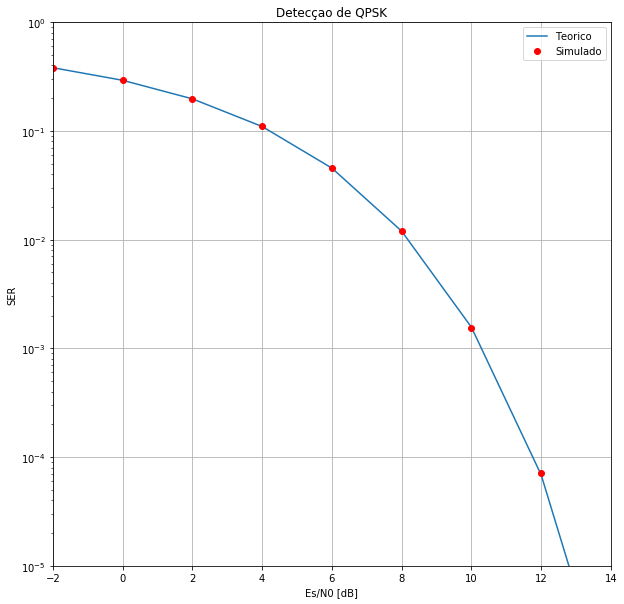

In [13]:
fig = plt.figure(figsize=(10,10))
plt.plot(EsN0dB, ser_theo, label='Teorico')
plt.plot(EsN0dB, ser_simu, 'ro', label='Simulado')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Es/N0 [dB]')
plt.ylabel('SER')
plt.grid(True)
plt.title('Detecçao de QPSK')
plt.legend()
plt.xlim([-2, 14])
plt.ylim([1e-5, 1])
plt.show()